In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import Callback
import matplotlib.pyplot as plt

In [2]:
train="DATASET/Tamil_Text/tamil_text_train.csv"
eval="DATASET/Tamil_Text/tamil_text_dev.csv"
test="DATASET/Tamil_Text/tamil_text_test.csv"

In [3]:
# Load data from CSV files
train_data = pd.read_csv(train)  
val_data = pd.read_csv(eval)
test_data = pd.read_csv(test)

In [4]:
# Preprocessing
# Convert text labels to numerical labels
label_encoder = LabelEncoder()
train_data['Emotion'] = label_encoder.fit_transform(train_data['Emotion'].astype(str))
val_data['Emotion'] = label_encoder.transform(val_data['Emotion'].astype(str))
test_data['Emotion'] = label_encoder.transform(test_data['Emotion'].astype(str))

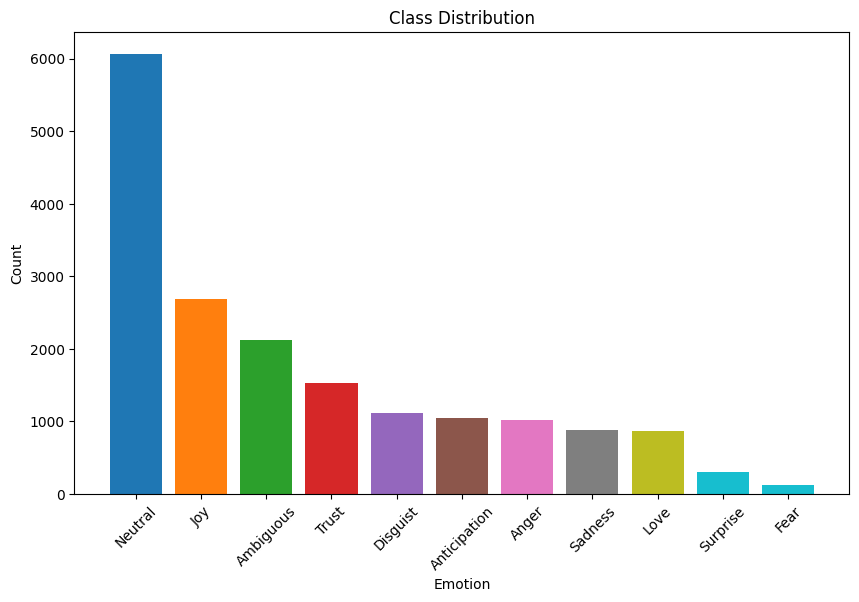

In [5]:
# Concatenate train and validation data for better visualization (optional)
combined_data = pd.concat([train_data, val_data])

# Count the occurrences of each class
class_counts = combined_data['Emotion'].value_counts()

# Get the class labels
class_labels = label_encoder.inverse_transform(class_counts.index)

# Define colors for each class
colors = plt.cm.tab10(np.arange(len(class_labels)))

# Plot the bar graph
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_counts,color=colors)
plt.title('Class Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [6]:
# Tokenize text data
max_features = 10000  # Number of words to consider as features
tokenizer = CountVectorizer(max_features=max_features)
tokenizer.fit(combined_data['Text'])

X_train = tokenizer.transform(train_data['Text']).toarray()
X_val = tokenizer.transform(val_data['Text']).toarray()
X_test = tokenizer.transform(test_data['Text']).toarray()


In [7]:
# Tokenize text data
max_features = 10000  # Number of words to consider as features
tokenizer = CountVectorizer(max_features=max_features)
tokenizer.fit(combined_data['Text'])

X_train = tokenizer.transform(train_data['Text']).toarray()
X_val = tokenizer.transform(val_data['Text']).toarray()
X_test = tokenizer.transform(test_data['Text']).toarray()

# Pad sequences
maxlen = 100  # Maximum sequence length
X_train = pad_sequences(X_train, maxlen=maxlen)
X_val = pad_sequences(X_val, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

# Prepare target labels
y_train = to_categorical(train_data['Emotion'])
y_val = to_categorical(val_data['Emotion'])
y_test = to_categorical(test_data['Emotion'])

139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
Metrics for Model 1:
Validation Accuracy: 0.34403154253959656
Test Accuracy: 0.34639638662338257
Precision: 0.11999046343640939
Recall: 0.3463963963963964
F1 Score: 0.17823943046425483




C:\Users\sides\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


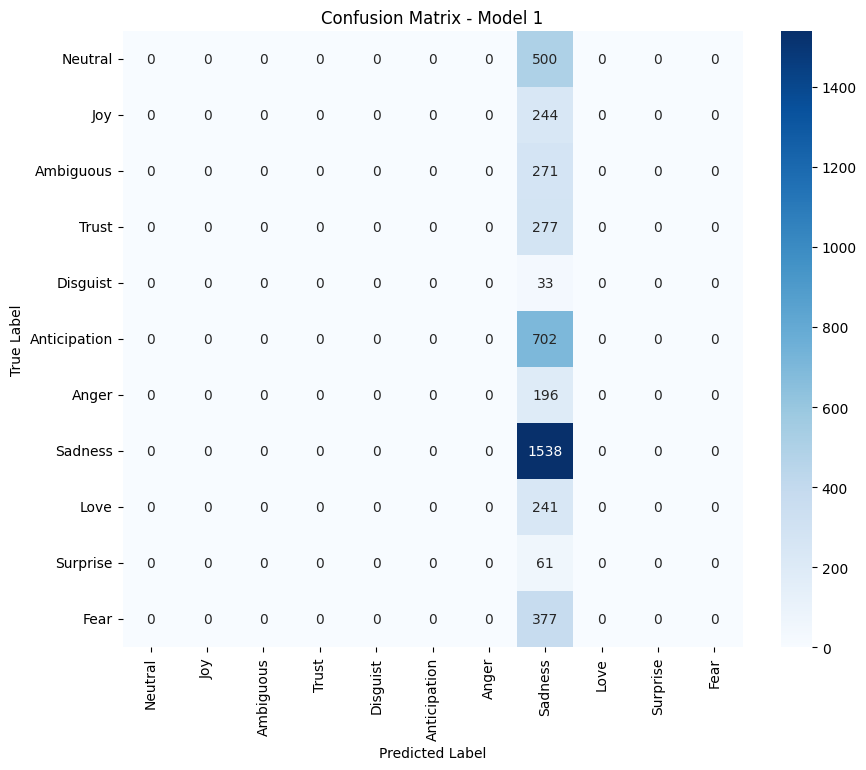

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define a function to train and evaluate a model
def train_and_evaluate_model(model, model_name):
    # Train the model
    history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_val, y_val), verbose=0)
    
    # Evaluate the model on validation and test sets
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    # Make predictions on test set
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Calculate additional metrics
    precision = precision_score(np.argmax(y_test, axis=1), y_pred, average='weighted')
    recall = recall_score(np.argmax(y_test, axis=1), y_pred, average='weighted')
    f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average='weighted')
    
    # Print evaluation metrics
    print(f"Metrics for {model_name}:")
    print("Validation Accuracy:", val_accuracy)
    print("Test Accuracy:", test_accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("\n")
    
    # Return evaluation metrics
    return {
        'Model': model_name,
        'Validation Accuracy': val_accuracy,
        'Test Accuracy': test_accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

# Train and evaluate each model
model_metrics = []

# Model 1
model1 = Sequential([
    Embedding(input_dim=max_features, output_dim=128),
    SpatialDropout1D(0.2),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dense(len(class_labels), activation='softmax')
])
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_metrics.append(train_and_evaluate_model(model1, "Model 1"))
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Train Model 1
history_model1 = model1.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_val, y_val), verbose=0)

# Evaluate Model 1 on test set
test_loss_model1, test_accuracy_model1 = model1.evaluate(X_test, y_test, verbose=0)

# Make predictions on test set
y_pred_prob_model1 = model1.predict(X_test)
y_pred_model1 = np.argmax(y_pred_prob_model1, axis=1)

# Confusion Matrix
conf_matrix_model1 = confusion_matrix(np.argmax(y_test, axis=1), y_pred_model1)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_model1, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Model 1')
plt.show()


139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step


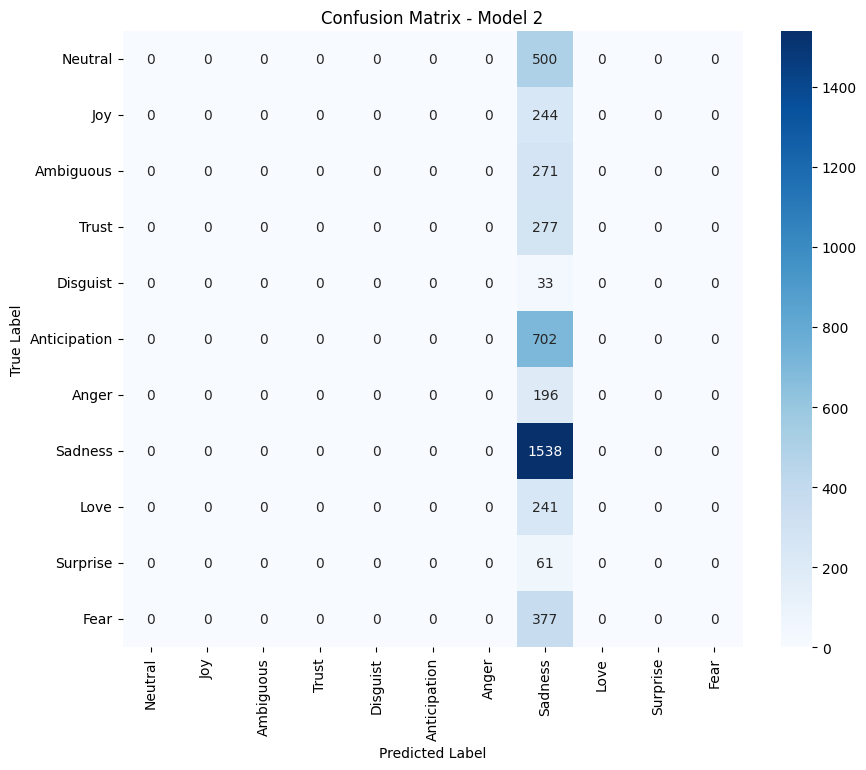

In [15]:
# Train Model 2
history_model2 = model2.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_val, y_val), verbose=0)

# Evaluate Model 2 on test set
test_loss_model2, test_accuracy_model2 = model2.evaluate(X_test, y_test, verbose=0)

# Make predictions on test set
y_pred_prob_model2 = model2.predict(X_test)
y_pred_model2 = np.argmax(y_pred_prob_model2, axis=1)

# Confusion Matrix
conf_matrix_model2 = confusion_matrix(np.argmax(y_test, axis=1), y_pred_model2)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_model2, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Model 2')
plt.show()


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


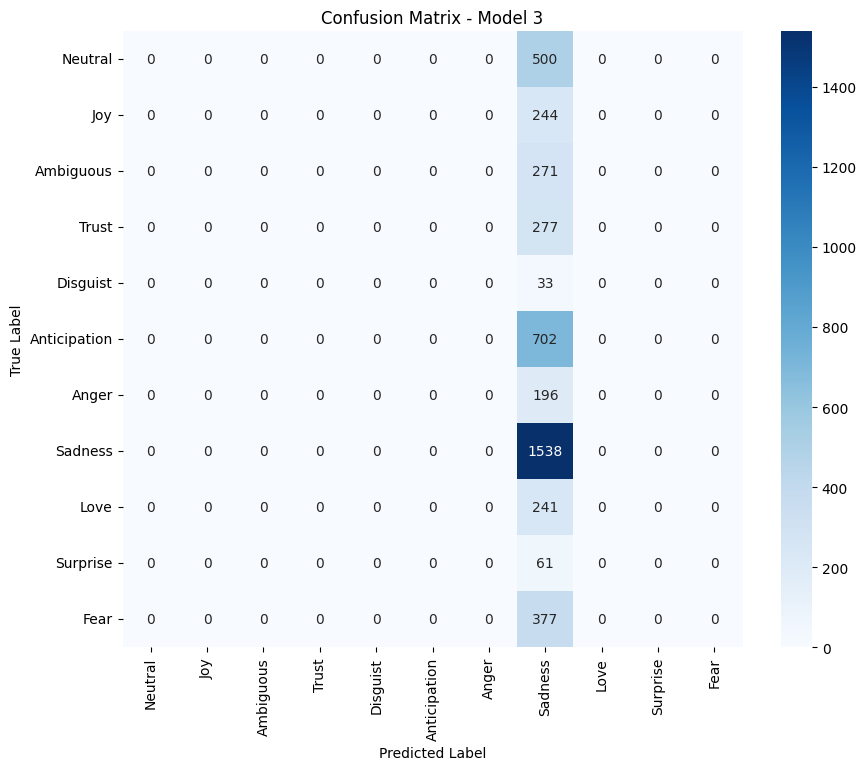

In [16]:
# Train Model 3
history_model3 = model3.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_val, y_val), verbose=0)

# Evaluate Model 3 on test set
test_loss_model3, test_accuracy_model3 = model3.evaluate(X_test, y_test, verbose=0)

# Make predictions on test set
y_pred_prob_model3 = model3.predict(X_test)
y_pred_model3 = np.argmax(y_pred_prob_model3, axis=1)

# Confusion Matrix
conf_matrix_model3 = confusion_matrix(np.argmax(y_test, axis=1), y_pred_model3)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_model3, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Model 3')
plt.show()


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, SpatialDropout1D, LSTM, Dense, Dropout

model3 = Sequential([
    Embedding(input_dim=max_features, output_dim=128),
    Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),
    SpatialDropout1D(0.3),
    LSTM(128, dropout=0.3, recurrent_dropout=0.3, return_sequences=True),
    LSTM(64, dropout=0.3, recurrent_dropout=0.3),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_labels), activation='softmax')
])
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step


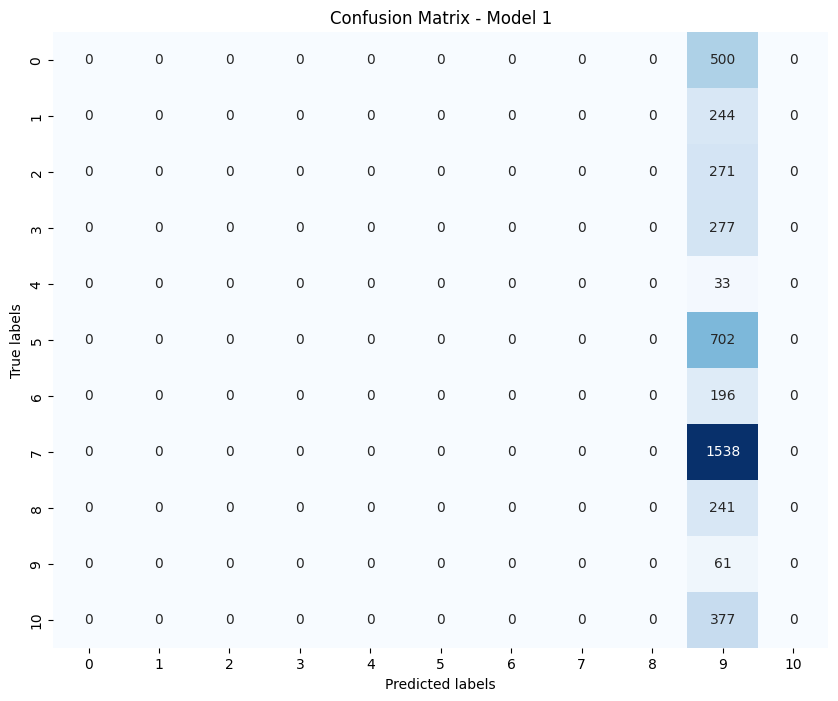

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Make predictions
y_pred_model1 = np.argmax(model1.predict(X_test), axis=1)

# Calculate confusion matrix
conf_matrix_model1 = confusion_matrix(np.argmax(y_test, axis=1), y_pred_model1)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_model1, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Model 1')
plt.show()


In [8]:
# Define the model architecture
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=128))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(class_labels), activation='softmax'))


In [9]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten

# Define the model architecture
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=128))
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(class_labels), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=128)

Epoch 1/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.2786 - loss: 2.2028
Epoch 2/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - accuracy: 0.3326 - loss: 2.0800
Epoch 3/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - accuracy: 0.3381 - loss: 2.0631
Epoch 4/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - accuracy: 0.3346 - loss: 2.0639
Epoch 5/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - accuracy: 0.3452 - loss: 2.0401
Epoch 6/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - accuracy: 0.3425 - loss: 2.0387
Epoch 7/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - accuracy: 0.3283 - loss: 2.0556
Epoch 8/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - accuracy: 0.3389 - loss: 2.0395
Epoch 9/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - accuracy: 0.3395 - loss: 2.0431
Epoch 10/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step - accuracy: 0.3363 - loss: 2.0500
Epoch 11/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 13s 114ms/step - accuracy: 0.3363 - loss: 2.0486
Epoch 12/20
111/111

In [12]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print("Validation Accuracy:", val_accuracy)

Validation Accuracy: 0.34403154253959656


In [13]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.34639638662338257


In [16]:
# Define the file path where you want to save the model
model_path = 'TAMIL_TEXT_EMO.h5'

# Save the model
model.save(model_path)

print("Model saved successfully at:", model_path)


Model saved successfully at: emotion_prediction_model_text.h5
